In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
file = "qRT_PEMF.xlsx"

plate1 = pd.read_excel(file,sheet_name="Plate1")
plate2 = pd.read_excel(file,sheet_name="Plate2")

In [5]:
plate1['CT'].replace('Undetermined', np.nan, inplace=True)
plate2['CT'].replace('Undetermined', np.nan, inplace=True)

In [53]:
# take mean of qRT-PCR technical duplicates
plate1_mean = plate1.groupby(['Gene', 'Sample_group', 'Replicate_w'], as_index=False)['CT'].mean()
plate2_mean = plate2.groupby(['Gene', 'Sample_group', 'Replicate_w'], as_index=False)['CT'].mean()
plate2_mean.head()

,Gene,Sample_group,Replicate_w,CT
0,ACTB,1hr,1,24.729699
1,ACTB,1hr,2,24.875835
2,ACTB,1hr,3,24.927697
3,ACTB,30min,1,24.959444
4,ACTB,30min,2,24.604655


# what is going on with IL-6 and the no RT? 

<Axes: xlabel='Sample_group', ylabel='CT'>

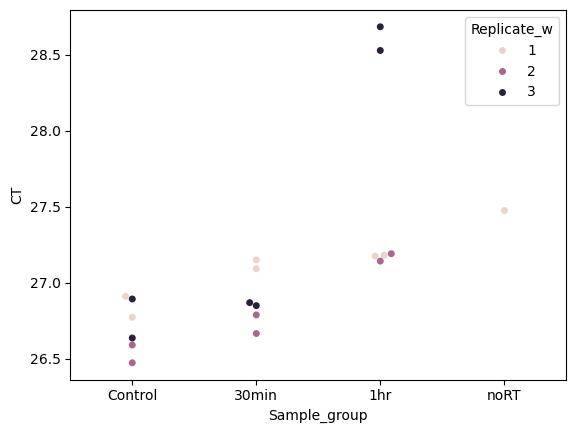

In [76]:
data = plate2.loc[plate2["Gene"]=="IL6"]
sns.swarmplot(x="Sample_group", y="CT", data=data, hue="Replicate_w")

# what is going on with replicate 3?

In [102]:
plate1.head()

,Plate,Position,Gene,Sample_group,Replicate_w,CT
0,Plate1,A01,COL1A1,Control,1,22.114399
1,Plate1,A02,COL1A1,Control,1,21.917530
2,Plate1,A03,COL1A1,Control,2,21.983702
3,Plate1,A04,COL1A1,Control,2,21.906300
4,Plate1,A05,COL1A1,Control,3,22.131327


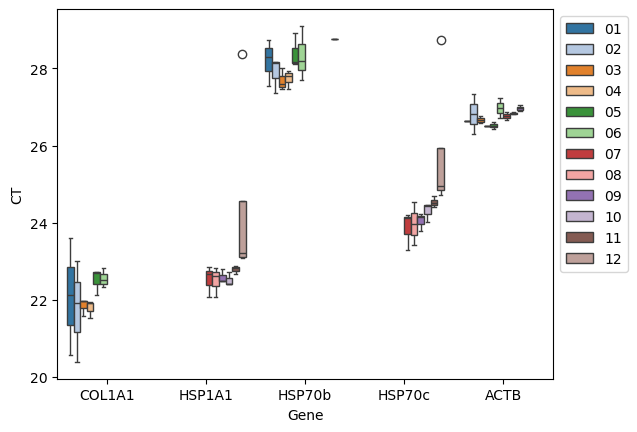

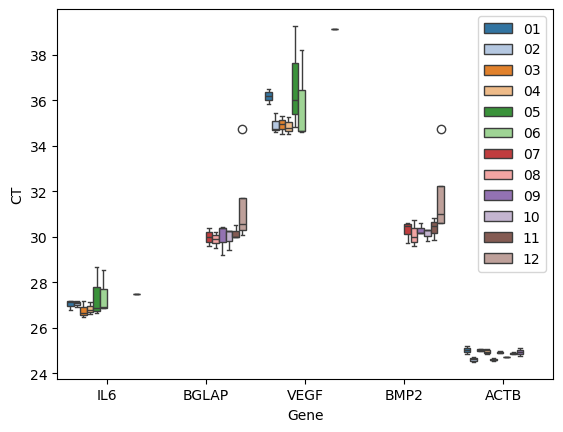

In [104]:
for plate in [plate1, plate2]:
    plate["pos"] = plate["Position"].apply(lambda x: "".join(list(x)[1:]))
    
    x="Gene"
    y="CT"
    hue="pos"
    data= plate
    sns.boxplot(x=x, y=y, data=data, hue=hue, palette="tab20")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

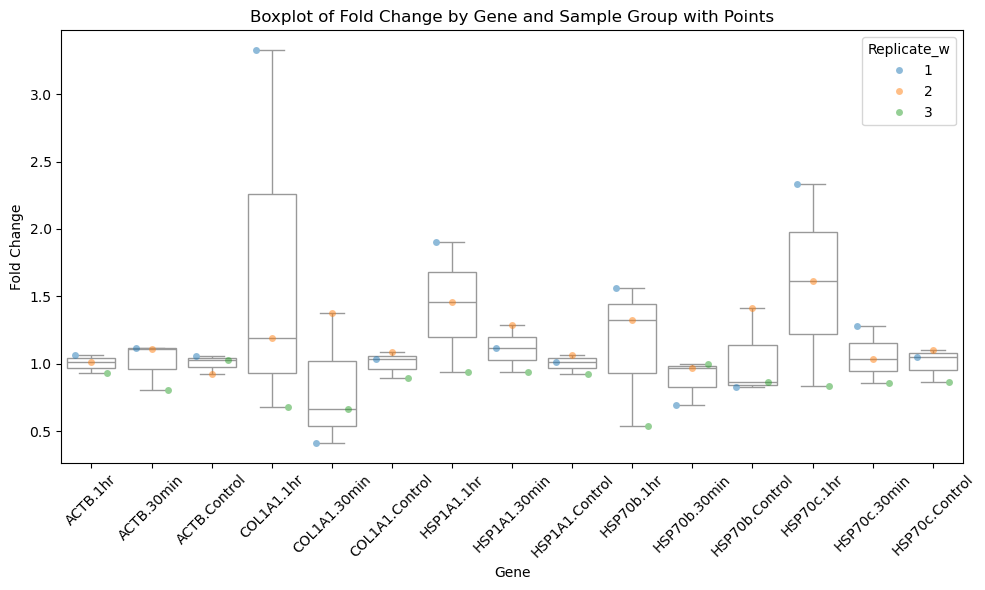

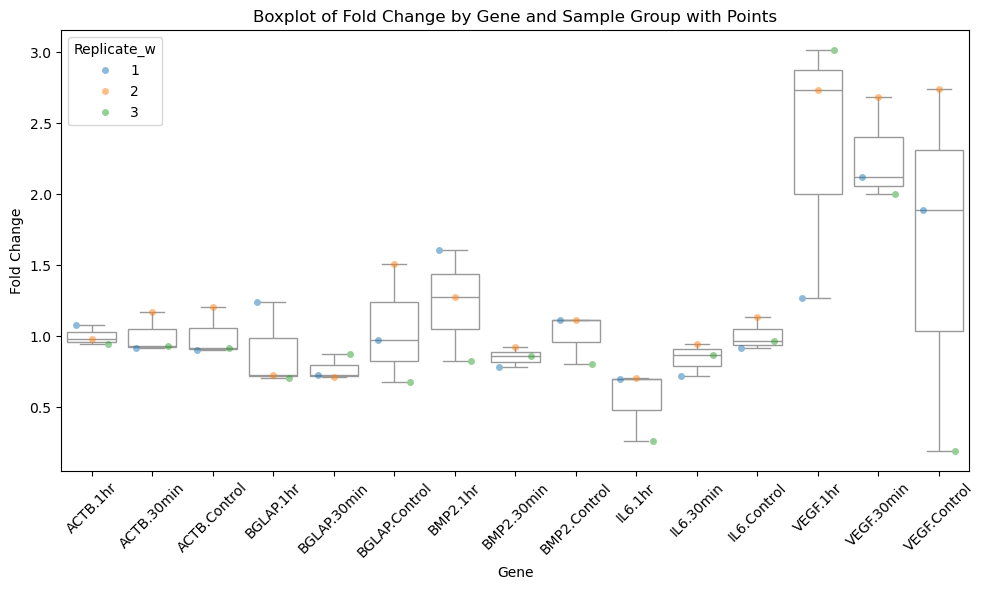

In [80]:
plate_lst =[plate1_mean, plate2_mean]
for n, plate in enumerate(plate_lst):
    df = plate.copy() # SF added .copy()
    
    # Calculate replicate average CT values for the ACTB control gene in each sample group
    control_gene_avg = df[df['Gene'] == 'ACTB'].groupby('Sample_group')['CT'].mean().reset_index()
    control_gene_avg.rename(columns={'CT': 'Control_mean'}, inplace=True)
    
    
    # Merge control gene average values back to the main DataFrame
    df = pd.merge(df, control_gene_avg, on='Sample_group', how='left')
    
    
    # Calculate dCT by subtracting the CT value from the control gene's AVERAGE CT value (instead of per-replicate)
    df['dCT'] = df['CT'] - df['Control_mean']
    
    
    df[df['Sample_group'] == 'Control']#.groupby(['Gene'])['dCT'].mean().reset_index()
    
    # Calculate average dCT values for the control samples for each gene
    # this first part does not make any sense because it takes th
    control_gene_dCT_avg = df[df['Sample_group'] == 'Control'].groupby(['Gene'])['dCT'].mean().reset_index()  
    control_gene_dCT_avg.rename(columns={'dCT': 'Control_dCT_mean'}, inplace=True)
    
    
    # Merge control group average dCT values back to the main DataFrame for each gene
    df = pd.merge(df, control_gene_dCT_avg, on='Gene', how='left')
    
    
    # Calculate ddCT by subtracting the average dCT of control samples for each gene from the dCT value
    df['ddCT'] = df['dCT'] - df['Control_dCT_mean']
    
    # Assuming 'df' contains the 'ddCT' values for each gene
    
    # Calculate fold change using the formula 2^(-ddCT)
    df['fold_change'] = 2 ** (-df['ddCT'])
    
    # Save to Excel or perform further operations as needed
    df.to_excel('plate1_output.xlsx', index=False)

    ## PLOT DATA!
    
    # create combination rep + timepoint annotation
    df["annot"] = df["Gene"] + "." + df["Sample_group"].astype(str)
    df =df.sort_values(by=["annot", "Sample_group"])
    df.head()
    
    # Assuming 'df' contains the 'fold_change' values, and you want to create a boxplot with points
    
    # Set up the boxplot and swarmplot using Seaborn
    plt.figure(figsize=(10, 6))
    data=df.loc[df['Sample_group']!="noRT"]
    sns.boxplot(data=data, 
                x='annot', y='fold_change', color = "w", #palette='Set2', 
                showfliers=False)
    sns.swarmplot(data=data, x='annot', y='fold_change', hue='Replicate_w', dodge=True, palette="tab10", 
                  #color='black', 
                  alpha=0.5)
    plt.xlabel('Gene')
    plt.ylabel('Fold Change')
    plt.title('Boxplot of Fold Change by Gene and Sample Group with Points')
    #plt.legend(title='Sample Group')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.savefig(f"plate.{n}.pdf", bbox_inches="tight")
    
    # Show the plot
    plt.show()


<Axes: xlabel='Gene', ylabel='fold_change'>

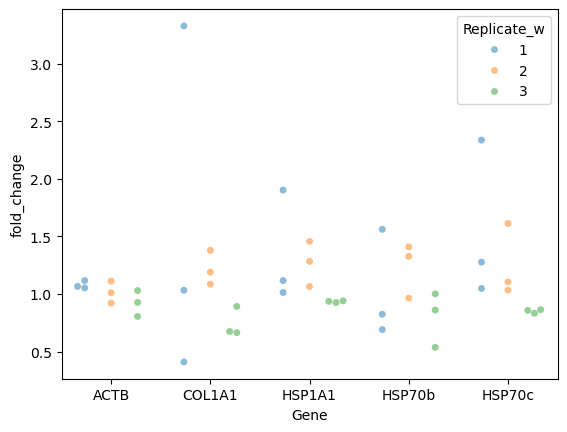

In [34]:
sns.swarmplot(data=df, x='Gene', y='fold_change', hue='Replicate_w', dodge=True, palette="tab10", 
              #color='black', 
              alpha=0.5)